# Using dask distributed cluster to speed up computation of PV potential by factor of 10

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from dask.distributed import Client
import core as core

import warnings
warnings.filterwarnings("ignore")
xr.__version__

'2024.2.0'

In [2]:
# location of era5 data on teachinghub
path="~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

Start dask cluster with 10 processes (workers), each with 5 threads. 

In [3]:
year = 2000
months = range(1, 12+1)
files = []

files = [f"era5-{year}-{month:02}.nc" for month in months]

files_path = [path+f for f in files]

print(f"Load data for {year=} {months=}")
files_path

Load data for year=2000 months=range(1, 13)


['~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-01.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-02.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-03.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-04.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-05.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-06.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-07.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-08.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-09.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-10.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-11.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-12.nc']

In [4]:
from pathlib import Path
home = Path.home()
dask_workspace = home / "daskWorkspace"

# Using Dask Client as a context manager
with Client(n_workers=20, threads_per_worker=4, local_directory=dask_workspace) as client:
    print(client)
    start_time = time.time()
    ds=xr.open_mfdataset(files_path, engine="h5netcdf", chunks={"valid_time":1e5}  )
    # ds=xr.open_mfdataset(files_path, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)

    pvpot = core.pv_pot(ds).groupby(ds.valid_time.dt.month).mean("valid_time").compute()
    # pvpot = core.pv_pot(ds).mean("valid_time").compute()
    end_time = time.time()
    execution_time = end_time - start_time
print(f"Execution time: {execution_time:.5f} seconds")

<Client: 'tcp://127.0.0.1:34409' processes=20 threads=80, memory=753.83 GiB>
Execution time: 138.55553 seconds


In [5]:
ds

<xarray.Dataset> Size: 219GB
Dimensions:     (valid_time: 8784, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 70kB 2000-01-01 ... 2000-12-31T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 141kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 36GB dask.array<chunksize=(744, 121, 240), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 36GB dask.array<chunksize=(744, 121, 240), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 36GB dask.array<chunksize=(744, 121, 240), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 36GB dask.array<chunksize=(744, 121, 240), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 36GB dask.array<chunksize=(744, 121, 240), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 36GB dask.array<chunksize=(744, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
print(f"{pvpot.shape}")
pvpot

(12, 721, 1440)


<xarray.DataArray (month: 12, latitude: 721, longitude: 1440)> Size: 50MB
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.48196262, 0.48198524, 0.4820098 , ..., 0.48184314,
         0.48187613, 0.4819154 ],
        [0.4816251 , 0.48164183, 0.48165774, ..., 0.4815678 ,
         0.48158753, 0.4816064 ],
        [0.4679344 , 0.4679344 , 0.4679344 , ..., 0.4679344 ,
         0.4679344 , 0.4679344 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.41012865, 0.41013625, 0.41014126, ..., 0.4100696 ,
         0.41008776, 0.41010714],
        [0.40905693, 0.40906295, 0.40906733, ..., 0.40901965,
         0.409032  , 0.40904516],
        [0.3937947 , 0.3937947 , 0.3937947 , ..., 0.3937947 ,
         0.3937947 , 0.3937947 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.55768853, 0.55769956, 0.55770415, ..., 0.557582  ,
         0.5576082 , 0.55764294],
        [0.55730903, 0.5573125 , 0.55731565, ..., 0.55726105,
         0.5572768 , 0.55729276],
        [0.54138875, 0.54138875, 0.54138875, ..., 0.54138875,
         0.54138875, 0.54138875]]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

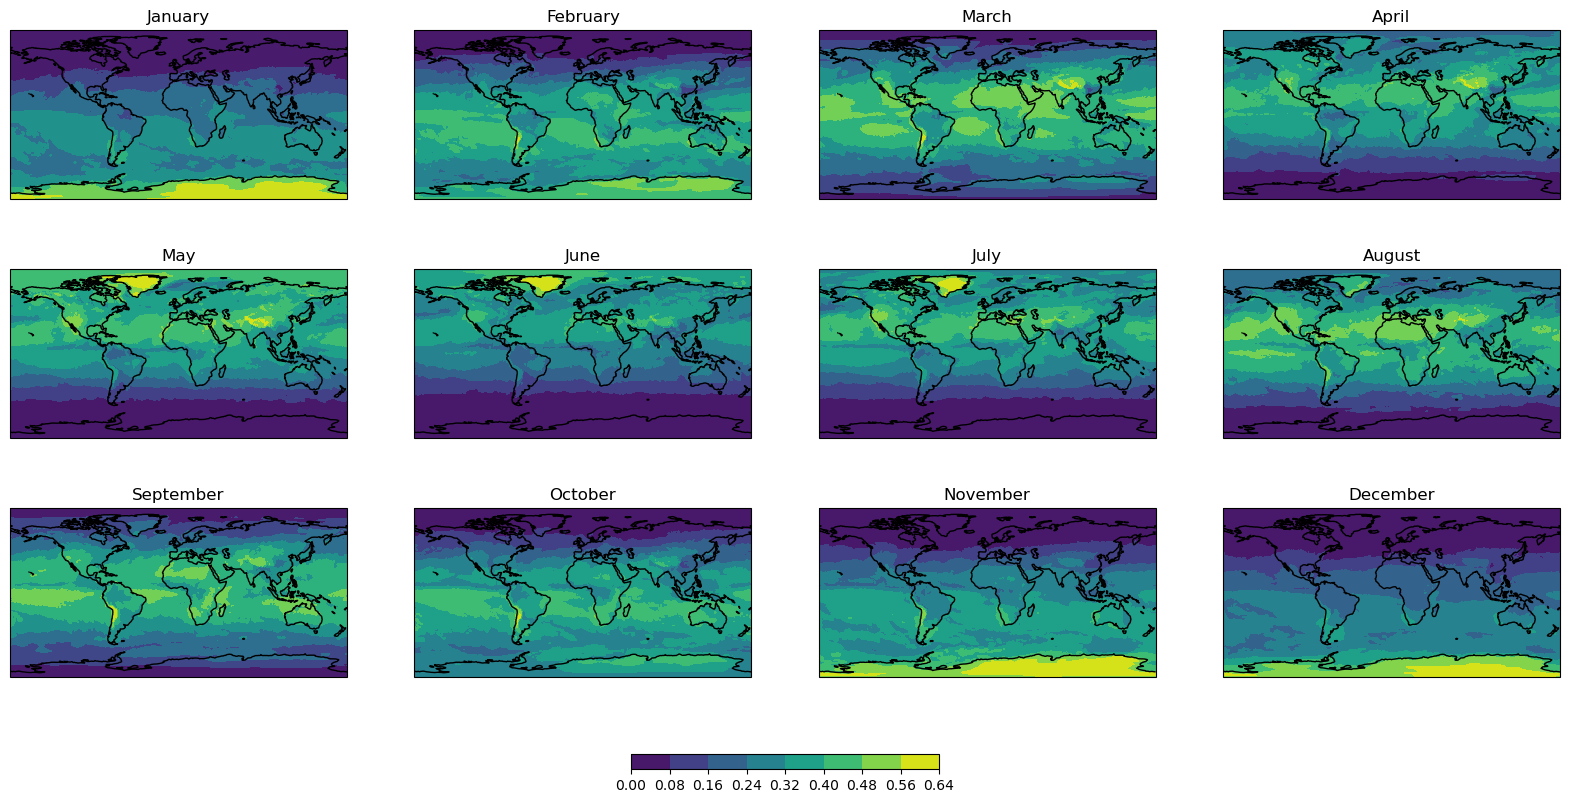

In [7]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig, axs = plt.subplots(figsize=(20, 10), nrows=3, ncols=4)
axs = axs.flatten()

for m in range(len(pvpot)):
    axs[m].add_feature(cfeature.COASTLINE)
    
    
    contour = axs[m].contourf(pvpot[m].longitude, pvpot[m].latitude, pvpot[m])
    axs[m].set_title(f"{calendar.month_name[m+1]}")
cbar = fig.colorbar(contour, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)



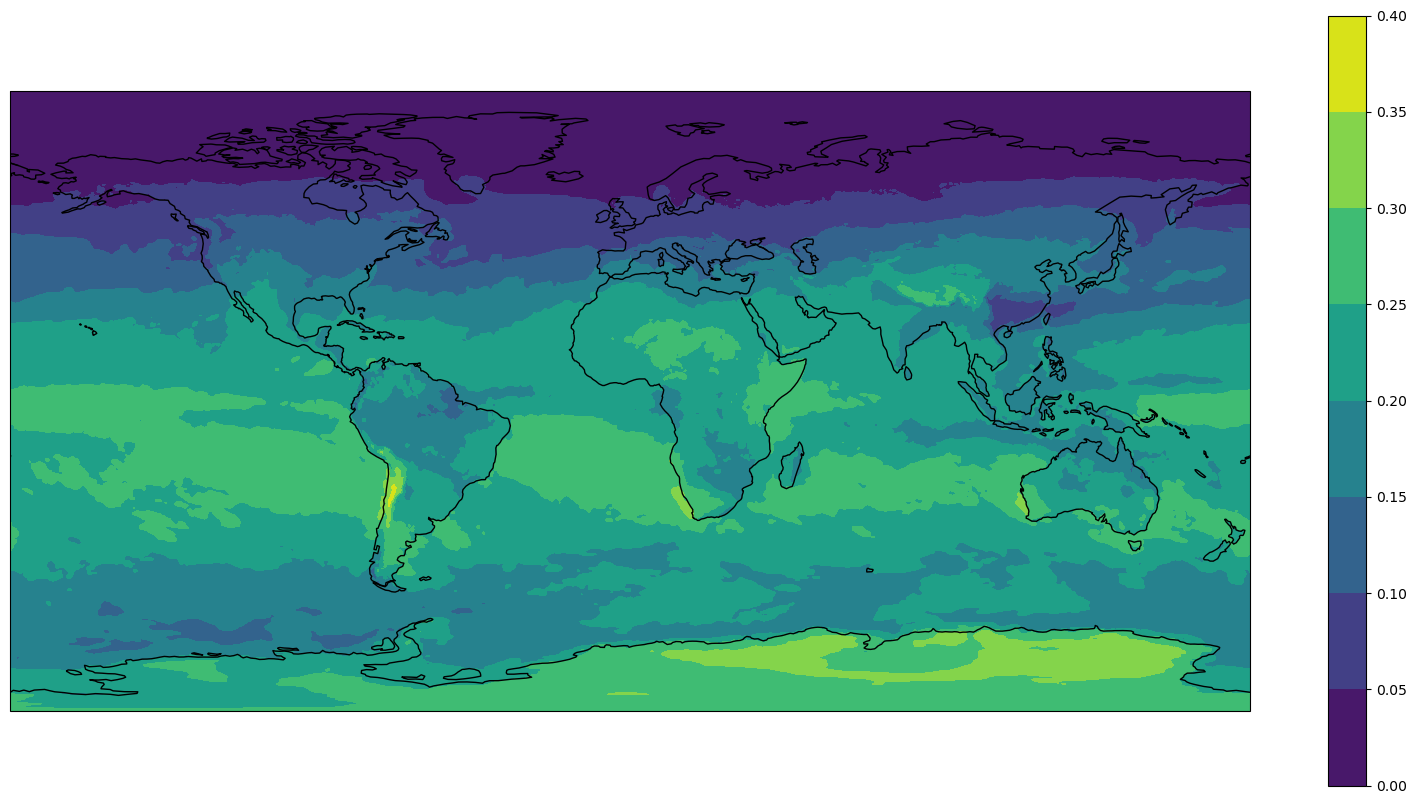

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create a figure with a specified projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and other features
ax.coastlines()
# ax.add_feature(cfeature.LAND)

# Create contour plot
contour = ax.contourf(ds.longitude, ds.latitude, pvpot[1])

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)